In [2]:
# import libs
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.applications import MobileNetV2
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import os
import numpy as np
# import matplotlib.pyplot as plt
from keras import regularizers

In [6]:
!pip install pillow

   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB 325.1 kB/s eta 0:00:08
   --- ------------------------------------ 0.2/2.6 MB 1.5 MB/s eta 0:00:02
   ---------- ----------------------------- 0.7/2.6 MB 3.7 MB/s eta 0:00:01
   ------------- -------------------------- 0.9/2.6 MB 4.0 MB/s eta 0:00:01
   ---------------- ----------------------- 1.1/2.6 MB 4.0 MB/s eta 0:00:01
   ----------------- ---------------------- 1.1/2.6 MB 3.8 MB/s eta 0:00:01
   ----------------- ---------------------- 1.1/2.6 MB 3.8 MB/s eta 0:00:01
   ------------------ --------------------- 1.2/2.6 MB 3.0 MB/s eta 0:00:01
   --------------------------- ------------ 1.8/2.6 MB 3.9 MB/s eta 0:00:01
   ------------------------------ ----


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
# Image directory
train_data_dir='data/train/'
validation_data_dir='data/test/'
# Resize input images to 224x224
# input_shape = (48, 48, 3)

In [8]:
# Initialize image data generator 
train_data_gen = ImageDataGenerator(rescale=1./255)

val_data_gen = ImageDataGenerator(rescale=1./255)

In [9]:
# Preprocessing
train_generator = train_data_gen.flow_from_directory(
					train_data_dir,
					color_mode='rgb',
					target_size=(48, 48),
					batch_size=64,
					class_mode='categorical')

val_generator = val_data_gen.flow_from_directory(
					validation_data_dir,
					color_mode='rgb',
					target_size=(48, 48),
					batch_size=64,
					class_mode='categorical')

class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']

img, label = train_generator.__next__()

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


ImportError: Could not import PIL.Image. The use of `load_img` requires PIL.

In [36]:
# Create model Structure
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(48,  48, 3))

# Build your model on top of VGG-16
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))  # 7 classes for emotions


# # Define input shape of MobileNet
# input_shape = (48, 48, 1)  # Adjust according to your image dimensions

# # Initialize model
# model = Sequential()

# # Convolutional layers
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Flatten layer
# model.add(Flatten())

# # Fully connected layers
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))

# # Output layer
# model.add(Dense(7, activation='softmax'))  # 7 classes for emotions


In [37]:
# Params
optim = Adam(learning_rate=0.0001, weight_decay=1e-6)

model.compile(optimizer=optim, loss='categorical_crossentropy', metrics = ['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 5120)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               1310976   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 3570759 (13.62 MB)
Trainable params: 3536647 (13.49 MB)
Non-trainable params: 34112 (133.25 KB)
__________

In [38]:
# Early stopping
# checkpoint =  ModelCheckpoint("model/model_25.weights.h5",monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=3,verbose=1,restore_best_weights=True)

# reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=3, verbose=1, min_delta=0.001)

callback_list = [ early_stopping]

In [39]:
train_path = "data/train/"
test_path = "data/test"

num_train_imgs = 0
for root, dirs, files in os.walk(train_path):
    num_train_imgs += len(files)
    
num_test_imgs = 0
for root, dirs, files in os.walk(test_path):
    num_test_imgs += len(files)

print(num_train_imgs)
print(num_test_imgs)

28709
7178


In [40]:
epochs=10


# Train the model/network
history = model.fit(
    train_generator,
    steps_per_epoch = num_train_imgs//64,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=num_test_imgs//64,
    callbacks=callback_list,
)

Epoch 1/10
448/448 [==============================] - 247s 398ms/step - loss: 2.3817 - accuracy: 0.2756 - val_loss: 2.2920 - val_accuracy: 0.3055
Epoch 2/10
448/448 [==============================] - 182s 407ms/step - loss: 2.0688 - accuracy: 0.3751 - val_loss: 2.2089 - val_accuracy: 0.3410
Epoch 3/10
448/448 [==============================] - 174s 387ms/step - loss: 1.9315 - accuracy: 0.4322 - val_loss: 2.2024 - val_accuracy: 0.3718
Epoch 4/10
448/448 [==============================] - 171s 382ms/step - loss: 1.8003 - accuracy: 0.4755 - val_loss: 2.2519 - val_accuracy: 0.4054
Epoch 5/10
448/448 [==============================] - 177s 396ms/step - loss: 1.6743 - accuracy: 0.5153 - val_loss: 1.8873 - val_accuracy: 0.4565
Epoch 6/10
448/448 [==============================] - 171s 381ms/step - loss: 1.5660 - accuracy: 0.5457 - val_loss: 1.8911 - val_accuracy: 0.4593
Epoch 7/10
448/448 [==============================] - 193s 430ms/step - loss: 1.4603 - accuracy: 0.5816 - val_loss: 1.7406 -

In [41]:
# # Save model structure in json 
# model_json = model.to_json()
# with open('model/model_loaded.json', 'w') as json_file:
#     json_file.write(model_json)

# Save trained model
model.save('model/model_10.h5')

In [ ]:
model_1 = load_model('model/model_10.h5')
model_1.fit(train_generator,
    steps_per_epoch = num_train_imgs//64,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=num_test_imgs//64,
    callbacks=callback_list,)

Epoch 1/10
448/448 [==============================] - 220s 411ms/step - loss: 1.3426 - accuracy: 0.6145 - val_loss: 1.7472 - val_accuracy: 0.5003
Epoch 2/10
448/448 [==============================] - ETA: 0s - loss: 1.2325 - accuracy: 0.6487

In [22]:
model_1.save('model/model_10.h5')

In [23]:
model_2 = load_model('model/model_10.h5')
model_2.fit(train_generator,
    steps_per_epoch = num_train_imgs//64,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=num_test_imgs//64,
    callbacks=callback_list,)

Epoch 1/10
448/448 [==============================] - 205s 381ms/step - loss: 0.5406 - accuracy: 0.8052 - val_loss: 1.7735 - val_accuracy: 0.5230
Epoch 2/10
448/448 [==============================] - 169s 377ms/step - loss: 0.4921 - accuracy: 0.8215 - val_loss: 1.8023 - val_accuracy: 0.5308
Epoch 3/10
448/448 [==============================] - 178s 397ms/step - loss: 0.4452 - accuracy: 0.8398 - val_loss: 1.7914 - val_accuracy: 0.5339
Epoch 4/10
448/448 [==============================] - 176s 391ms/step - loss: 0.4098 - accuracy: 0.8535 - val_loss: 1.8771 - val_accuracy: 0.5432
Epoch 4: early stopping


In [25]:
model_2.save('model/model_10.h5')

In [26]:
model_3 = load_model('model/model_10.h5')
model_3.fit(train_generator,
    steps_per_epoch = num_train_imgs//64,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=num_test_imgs//64,
    callbacks=callback_list,)

Epoch 1/10
448/448 [==============================] - 211s 392ms/step - loss: 0.4799 - accuracy: 0.8259 - val_loss: 1.7935 - val_accuracy: 0.5388
Epoch 2/10
448/448 [==============================] - 166s 371ms/step - loss: 0.4480 - accuracy: 0.8404 - val_loss: 1.9025 - val_accuracy: 0.5332
Epoch 3/10
448/448 [==============================] - 171s 382ms/step - loss: 0.4058 - accuracy: 0.8540 - val_loss: 1.8839 - val_accuracy: 0.5343
Epoch 4/10
448/448 [==============================] - 170s 379ms/step - loss: 0.3696 - accuracy: 0.8684 - val_loss: 2.0428 - val_accuracy: 0.5458
Epoch 4: early stopping


In [27]:
model_3.save('model/model_10.h5')

In [28]:
model_4 = load_model('model/model_10.h5')
model_4.fit(train_generator,
    steps_per_epoch = num_train_imgs//64,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=num_test_imgs//64,
    callbacks=callback_list,)

Epoch 1/10
448/448 [==============================] - 211s 391ms/step - loss: 0.4523 - accuracy: 0.8393 - val_loss: 1.9388 - val_accuracy: 0.5402
Epoch 2/10
448/448 [==============================] - 168s 374ms/step - loss: 0.4062 - accuracy: 0.8552 - val_loss: 1.8764 - val_accuracy: 0.5405
Epoch 3/10
448/448 [==============================] - 171s 381ms/step - loss: 0.3747 - accuracy: 0.8654 - val_loss: 1.9971 - val_accuracy: 0.5523
Epoch 4/10
448/448 [==============================] - 170s 380ms/step - loss: 0.3361 - accuracy: 0.8819 - val_loss: 2.0949 - val_accuracy: 0.5364
Epoch 5/10
448/448 [==============================] - 172s 383ms/step - loss: 0.3272 - accuracy: 0.8845 - val_loss: 2.2258 - val_accuracy: 0.5308
Epoch 5: early stopping


In [29]:
model_4.save('model/model_10.h5')

In [31]:
model_5 = load_model('model/model_10.h5')
model_5.fit(train_generator,
    steps_per_epoch = num_train_imgs//64,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=num_test_imgs//64,
    callbacks=callback_list,)
model_5.save('model/model_10.h5')

Epoch 1/10
448/448 [==============================] - 200s 376ms/step - loss: 0.3753 - accuracy: 0.8681 - val_loss: 2.0741 - val_accuracy: 0.5484
Epoch 2/10
448/448 [==============================] - 162s 361ms/step - loss: 0.3489 - accuracy: 0.8776 - val_loss: 2.2547 - val_accuracy: 0.5442
Epoch 3/10
448/448 [==============================] - 177s 394ms/step - loss: 0.3209 - accuracy: 0.8868 - val_loss: 2.2196 - val_accuracy: 0.5340
Epoch 4/10
448/448 [==============================] - 180s 403ms/step - loss: 0.3029 - accuracy: 0.8942 - val_loss: 2.3444 - val_accuracy: 0.5254
Epoch 4: early stopping


In [39]:
import pickle

# Save the model to a file
with open('model/model.pkl', 'wb') as file:
    pickle.dump(model, file)



In [40]:
# Load the model from a file
with open('model/model.pkl', 'rb') as file:
    model_loaded7 = pickle.load(file)

In [18]:
pred=model.predict(val_generator,steps=num_test_imgs//64)
final_predict=np.argmax(pred,axis=1)
true_data=val_generator.classes

112/112 [==============================] - 24s 179ms/step


In [19]:
print(len(true_data))
print(len(final_predict))

7178
7168


In [20]:
from sklearn.metrics import accuracy_score

# Truncate the longer array to match the length of the shorter array
min_length = min(len(true_data), len(final_predict))
true_data = true_data[:min_length]
final_predict = final_predict[:min_length]
print("Accuracy Score is",accuracy_score(true_data,final_predict))

Accuracy Score is 0.17466517857142858


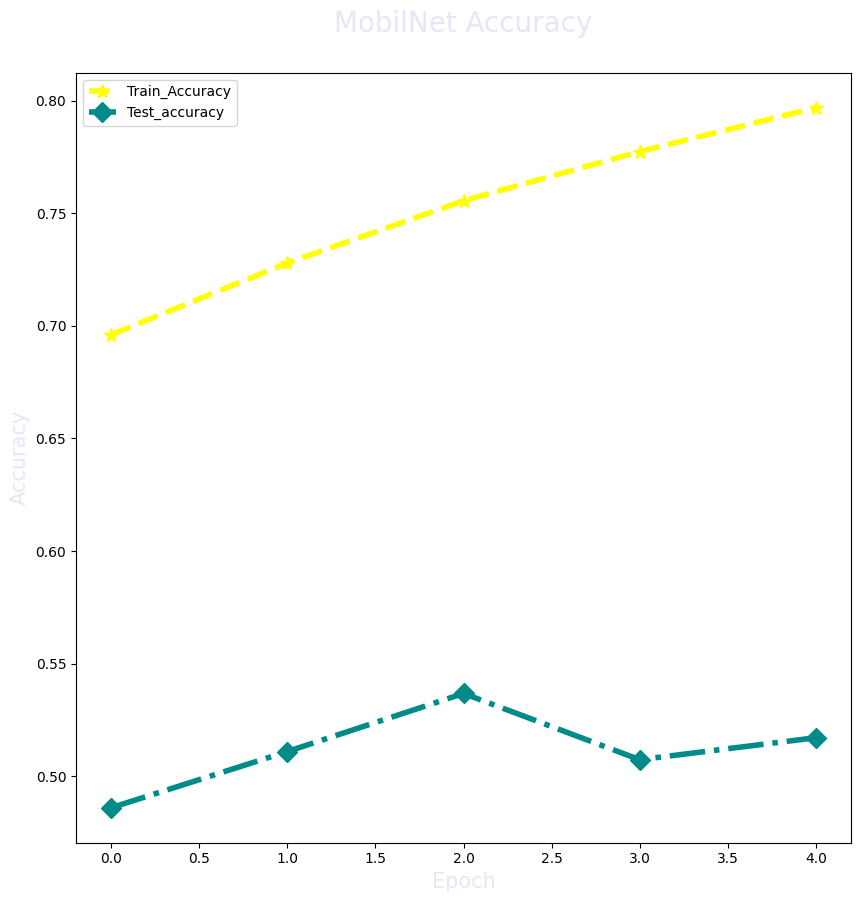

In [30]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'], marker="*", linestyle="--", color="yellow", markersize=10, lw=4)
plt.plot(history.history['val_accuracy'], marker="D", linestyle="-.", color="darkcyan", markersize=10, lw=4)
plt.title('MobilNet Accuracy\n', color="lavender", fontsize=20)
plt.ylabel('Accuracy', color="lavender", fontsize=15)
plt.xlabel('Epoch', color="lavender", fontsize=15)
plt.legend(['Train_Accuracy', 'Test_accuracy'], loc='upper left')
plt.show()